In [5]:
import os
from itertools import product

import numpy as np

from ml.eval import eval_model

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

from ml.pipeline import FeitDataPipeline
from ml.util import NeighborhoodImageDataGenerator, rename_keras_layer

from tensorflow import keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.callbacks import ReduceLROnPlateau

from cfg import *

from livelossplot import PlotLossesKerasTF

name = "MySimpleCNN_Inception_module-v2-reduced-neighborhood-concatenate"


/home/jelinek/recetox


In [6]:
class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, neighborhood_tiles: int, *args, **kwargs):

        self.neighborhood_tiles: int = neighborhood_tiles

        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256



    def get_optimizer(self):
        lr_schedule = schedules.ExponentialDecay(
            initial_learning_rate=1e-2,
            decay_steps=80,
            decay_rate=0.1,
            staircase=True)

        return Adam(
            # learning_rate=0.1,
            learning_rate=lr_schedule,
            beta_1=0.99,
            beta_2=0.9999)



    @staticmethod
    def __get_basic_layers(model_idx: int):
        trained_base_model = keras.models.load_model('saved-models/frozen/MySimpleCnn_Feit-inceptionv2-reduced.h5')
        trained_base_model.trainable = False

        name_suffix = '_model_tile_' + str(model_idx)

        for i in range(len(trained_base_model.layers)):
            rename_keras_layer(trained_base_model, trained_base_model.layers[i],
                               trained_base_model.layers[i].name + name_suffix)

        last_layer = trained_base_model(trained_base_model.inputs, training=False)

        rename_keras_layer(trained_base_model, last_layer, last_layer.name + name_suffix)

        trained_base_model._name += name_suffix
        return trained_base_model.inputs[0], last_layer


    @staticmethod
    def get_compiled_model():
        neighborhood = 1
        neighborhood_size = 2 * neighborhood + 1


        neighborhood_networks = [MySimpleCNNInceptionModule.__get_basic_layers(model_idx)
                                 for model_idx in range(neighborhood_size ** 2)]

        outputs = [model[1] for model in neighborhood_networks]

        merge_layer = keras.layers.Concatenate()(outputs)

        x = keras.layers.Dense(units=12, activation='sigmoid')(merge_layer)

        output = keras.layers.Dense(units = 12, activation = 'softmax')(x)

        inputs = [model[0] for model in neighborhood_networks]
        model = keras.Model(inputs=inputs, outputs=output)
        model.summary()

        return model


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=9,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

    def get_data_loader_training(self):
        datagen_train = NeighborhoodImageDataGenerator(self.neighborhood_tiles, horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)
        tiles_per_axis = self.neighborhood_tiles * 2 + 1

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size * tiles_per_axis,
                                                              self.params.tile_size * tiles_per_axis))

    def get_data_loader_validation(self):
        datagen_valid = NeighborhoodImageDataGenerator(self.neighborhood_tiles, samplewise_center=True, samplewise_std_normalization=True)
        tiles_per_axis = self.neighborhood_tiles * 2 + 1

        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size * tiles_per_axis,
                                                              self.params.tile_size * tiles_per_axis))

    def get_datagen_segmentation(self):
        return NeighborhoodImageDataGenerator(self.neighborhood_tiles, samplewise_center=True,
                                              samplewise_std_normalization=True)



In [7]:
pipeline = MySimpleCNNInceptionModule(neighborhood_tiles=1,
                                      train_data_dir='data/Feit_colon-annotation-tiles-256-1-neighborhood/data_train/',
                                      valid_data_dir='data/Feit_colon-annotation-tiles-256-1-neighborhood/data_valid/')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_model_tile_0 (InputLaye [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_1_model_tile_1 (InputLaye [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_1_model_tile_2 (InputLaye [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_1_model_tile_3 (InputLaye [(None, 256, 256, 3) 0                                            
____________________________________________________________________________________________

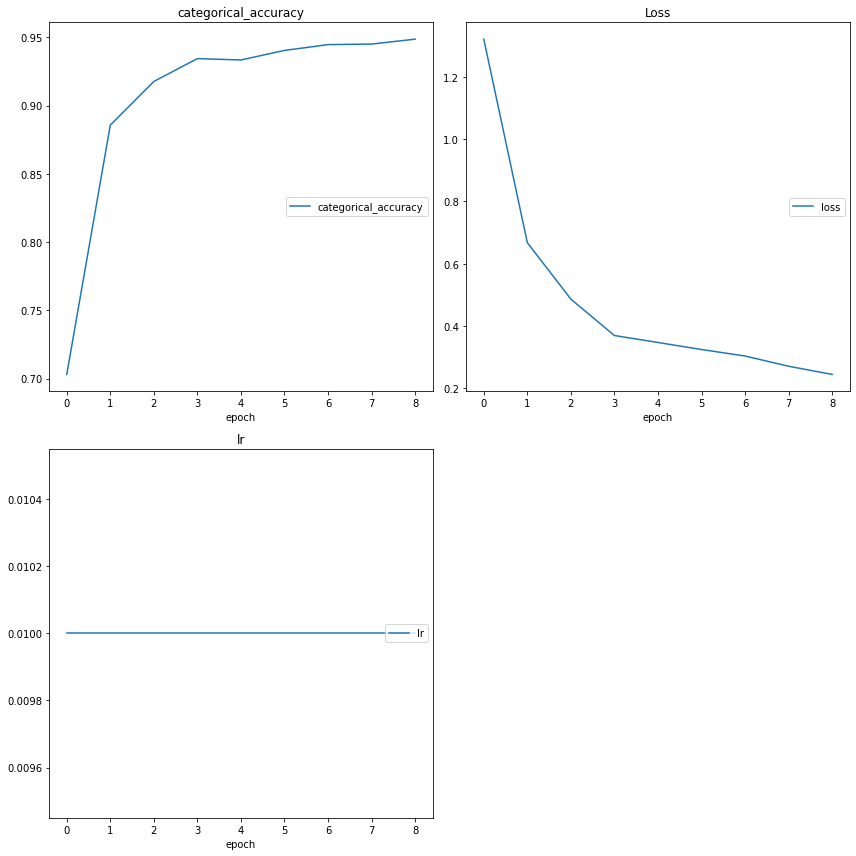

categorical_accuracy
	categorical_accuracy 	 (min:    0.703, max:    0.949, cur:    0.949)
Loss
	loss             	 (min:    0.245, max:    1.321, cur:    0.245)
lr
	lr               	 (min:    0.010, max:    0.010, cur:    0.010)


In [8]:
pipeline.execute_pipeline(perform_validation=False, perform_test_segmentation=False)

In [9]:
pipeline.save_pipeline()

In [11]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [12]:
path = Path('data/Kather_5000')
from util.data_manipulation_scripts import generate_image_annotation_pairs

tiffs, _ = generate_image_annotation_pairs(Path('data/Feit_colon-annotation'))
for tiff in tiffs:
    pipeline.perform_segmentation(tiff, step=256)

Segmenting file 1 out of 1
Processing region 1 out of 104

ValueError: in user code:

    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1552 run_step  **
        outputs = model.predict_step(data)
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1525 predict_step
        return self(x, training=False)
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_1: expected shape=(None, 256, 256, 3), found shape=(None, 85, 85, 3)
